In [104]:
# %pip install pipenv
# %pip install scikit-learn
# %pip install seaborn
# %pip install matplotlib
# %pip install numpy
# %pip install tensorflow
# %pip install xgboost
# %pip install ipympl
%matplotlib widget


In [105]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [106]:
train_dataset = pd.read_csv('train.csv')
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [107]:
train_dataset.head(n=10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [150]:
class DataAnalyzer():
    def __init__(self):
        self.__x = None
        self.__y = None
        self.numerical_features = []
        self.categorical_features = []
        self.df_target_corr = None
        self.df_feature_correlation = None

    def fit(self, x_set, y_set):
        self.__x = x_set
        self.__y = y_set
        all_cnt = len(x_set)
        self.numerical_features = list(x_set.select_dtypes(include=np.number).columns)
        self.categorical_features = list(x_set.select_dtypes(exclude=np.number).columns)
        for col in x_set.columns:
            ds = x_set[col]
            unique = ds.unique()
            n_unique = len(unique)
            null_cnt = ds.isnull().sum()
            null_prc = null_cnt/all_cnt
            print(col)
            print(f' => dtype: {ds.dtype}')
            if null_cnt > 0:
                print(f' => nulls {null_cnt} ({100*null_prc:.0f}%)')
            print(f' => unique ({n_unique})', '...' if n_unique > 20 else unique)
        
        if not y_set is None:
            x_numerical = x_set[self.numerical_features]
            self.df_target_corr = pd.DataFrame(data=x_numerical.corrwith(y_set), columns=['y']) 
            self.df_feature_correlation = x_numerical.corr()


    def get_target_correlated(self, min_threshold=0.3):
        threshold_cond = abs(self.df_target_corr.iloc[:,0]) > min_threshold
        selected_num_features = list(self.df_target_corr[threshold_cond].index)
        return selected_num_features
    
    def get_correlated_features(self, min_threshold=0.5):
        correlated_pairs = []
        columns = list(self.df_feature_correlation.columns)
        for i,col in enumerate(columns):
            for j in range(i+1, len(columns)):
                c = self.df_feature_correlation.iloc[i,j]
                if abs(c) > min_threshold:
                    correlated_pairs.append((columns[i], columns[j]))
        return correlated_pairs
    
    def plot_input_pdfs(self, h_cols=4, fig_size_x=15):
        self.__plot_pdfs(self.__x[self.numerical_features], h_cols, fig_size_x)

    def plot_output_pdfs(self, h_cols=1, fig_size_x=5):
        self.__plot_pdfs(self.__y, h_cols, fig_size_x)

    def plot_feature_target_xy(self, h_cols=4):
        self.__plot_feature_target_xy(self.__x[self.numerical_features], self.__y, h_cols)

    def __plot_pdfs(self, df, h_cols, fig_size_x):
        h_rows = math.ceil(len(df.columns) / h_cols)
        fig, axes = plt.subplots(h_rows, h_cols, figsize=(fig_size_x, 3*h_rows))
        axes = axes.flatten() if type(axes) is np.ndarray else [axes]
        for i, col in enumerate(df.columns):
            ax = axes[i]
            df[col].hist(ax=ax, bins=25)
            ax.set_title(col)
        plt.tight_layout()
        plt.show()    

    def __plot_feature_target_xy(self, df_inputs, df_target, h_cols):
        h_rows = math.ceil(len(df_inputs.columns) / h_cols)
        fix2, axes2 = plt.subplots(h_rows, h_cols, figsize=(15,4 * h_rows), sharey=True)
        axes2 = axes2.flatten()
        for i, col in enumerate(df_inputs.columns):
            ax = axes2[i]
            ax.scatter(df_inputs[col], df_target[df_target.columns[0]])
            ax.set_title(col)
        plt.show()


In [151]:
X_dataset = train_dataset.iloc[:,:-1]
Y_dataset = train_dataset.iloc[:,-1:]

In [152]:
data_analyzer = DataAnalyzer()
data_analyzer.fit(X_dataset, Y_dataset)
print('Numerical features', data_analyzer.numerical_features)
print('Categorical features', data_analyzer.categorical_features)

Id
 => dtype: int64
 => unique (1460) ...
MSSubClass
 => dtype: int64
 => unique (15) [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
MSZoning
 => dtype: object
 => unique (5) ['RL' 'RM' 'C (all)' 'FV' 'RH']
LotFrontage
 => dtype: float64
 => nulls 259 (18%)
 => unique (111) ...
LotArea
 => dtype: int64
 => unique (1073) ...
Street
 => dtype: object
 => unique (2) ['Pave' 'Grvl']
Alley
 => dtype: object
 => nulls 1369 (94%)
 => unique (3) [nan 'Grvl' 'Pave']
LotShape
 => dtype: object
 => unique (4) ['Reg' 'IR1' 'IR2' 'IR3']
LandContour
 => dtype: object
 => unique (4) ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities
 => dtype: object
 => unique (2) ['AllPub' 'NoSeWa']
LotConfig
 => dtype: object
 => unique (5) ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope
 => dtype: object
 => unique (3) ['Gtl' 'Mod' 'Sev']
Neighborhood
 => dtype: object
 => unique (25) ...
Condition1
 => dtype: object
 => unique (9) ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2

In [138]:
data_analyzer.df_target_corr

,y
1stFlrSF,NaN
2ndFlrSF,NaN
3SsnPorch,NaN
BedroomAbvGr,NaN
BsmtFinSF1,NaN
BsmtFinSF2,NaN
BsmtFullBath,NaN
BsmtHalfBath,NaN
BsmtUnfSF,NaN
EnclosedPorch,NaN


### Highly correlated numerical features with the target 

In [139]:
data_analyzer.get_target_correlated()

[]

In [140]:
data_analyzer.get_correlated_features()

[('OverallQual', 'YearBuilt'),
 ('OverallQual', 'YearRemodAdd'),
 ('OverallQual', 'TotalBsmtSF'),
 ('OverallQual', 'GrLivArea'),
 ('OverallQual', 'FullBath'),
 ('OverallQual', 'GarageYrBlt'),
 ('OverallQual', 'GarageCars'),
 ('OverallQual', 'GarageArea'),
 ('YearBuilt', 'YearRemodAdd'),
 ('YearBuilt', 'GarageYrBlt'),
 ('YearBuilt', 'GarageCars'),
 ('YearRemodAdd', 'GarageYrBlt'),
 ('BsmtFinSF1', 'TotalBsmtSF'),
 ('BsmtFinSF1', 'BsmtFullBath'),
 ('TotalBsmtSF', '1stFlrSF'),
 ('1stFlrSF', 'GrLivArea'),
 ('2ndFlrSF', 'GrLivArea'),
 ('2ndFlrSF', 'HalfBath'),
 ('2ndFlrSF', 'BedroomAbvGr'),
 ('2ndFlrSF', 'TotRmsAbvGrd'),
 ('GrLivArea', 'FullBath'),
 ('GrLivArea', 'BedroomAbvGr'),
 ('GrLivArea', 'TotRmsAbvGrd'),
 ('FullBath', 'TotRmsAbvGrd'),
 ('BedroomAbvGr', 'TotRmsAbvGrd'),
 ('GarageYrBlt', 'GarageCars'),
 ('GarageYrBlt', 'GarageArea'),
 ('GarageCars', 'GarageArea')]

## Histograms

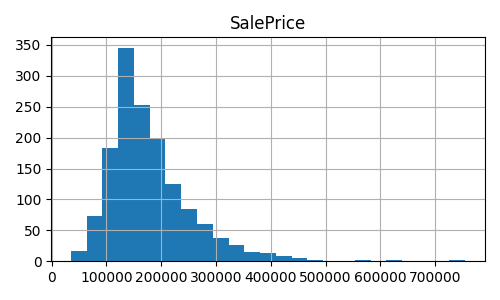

In [141]:
data_analyzer.plot_output_pdfs()

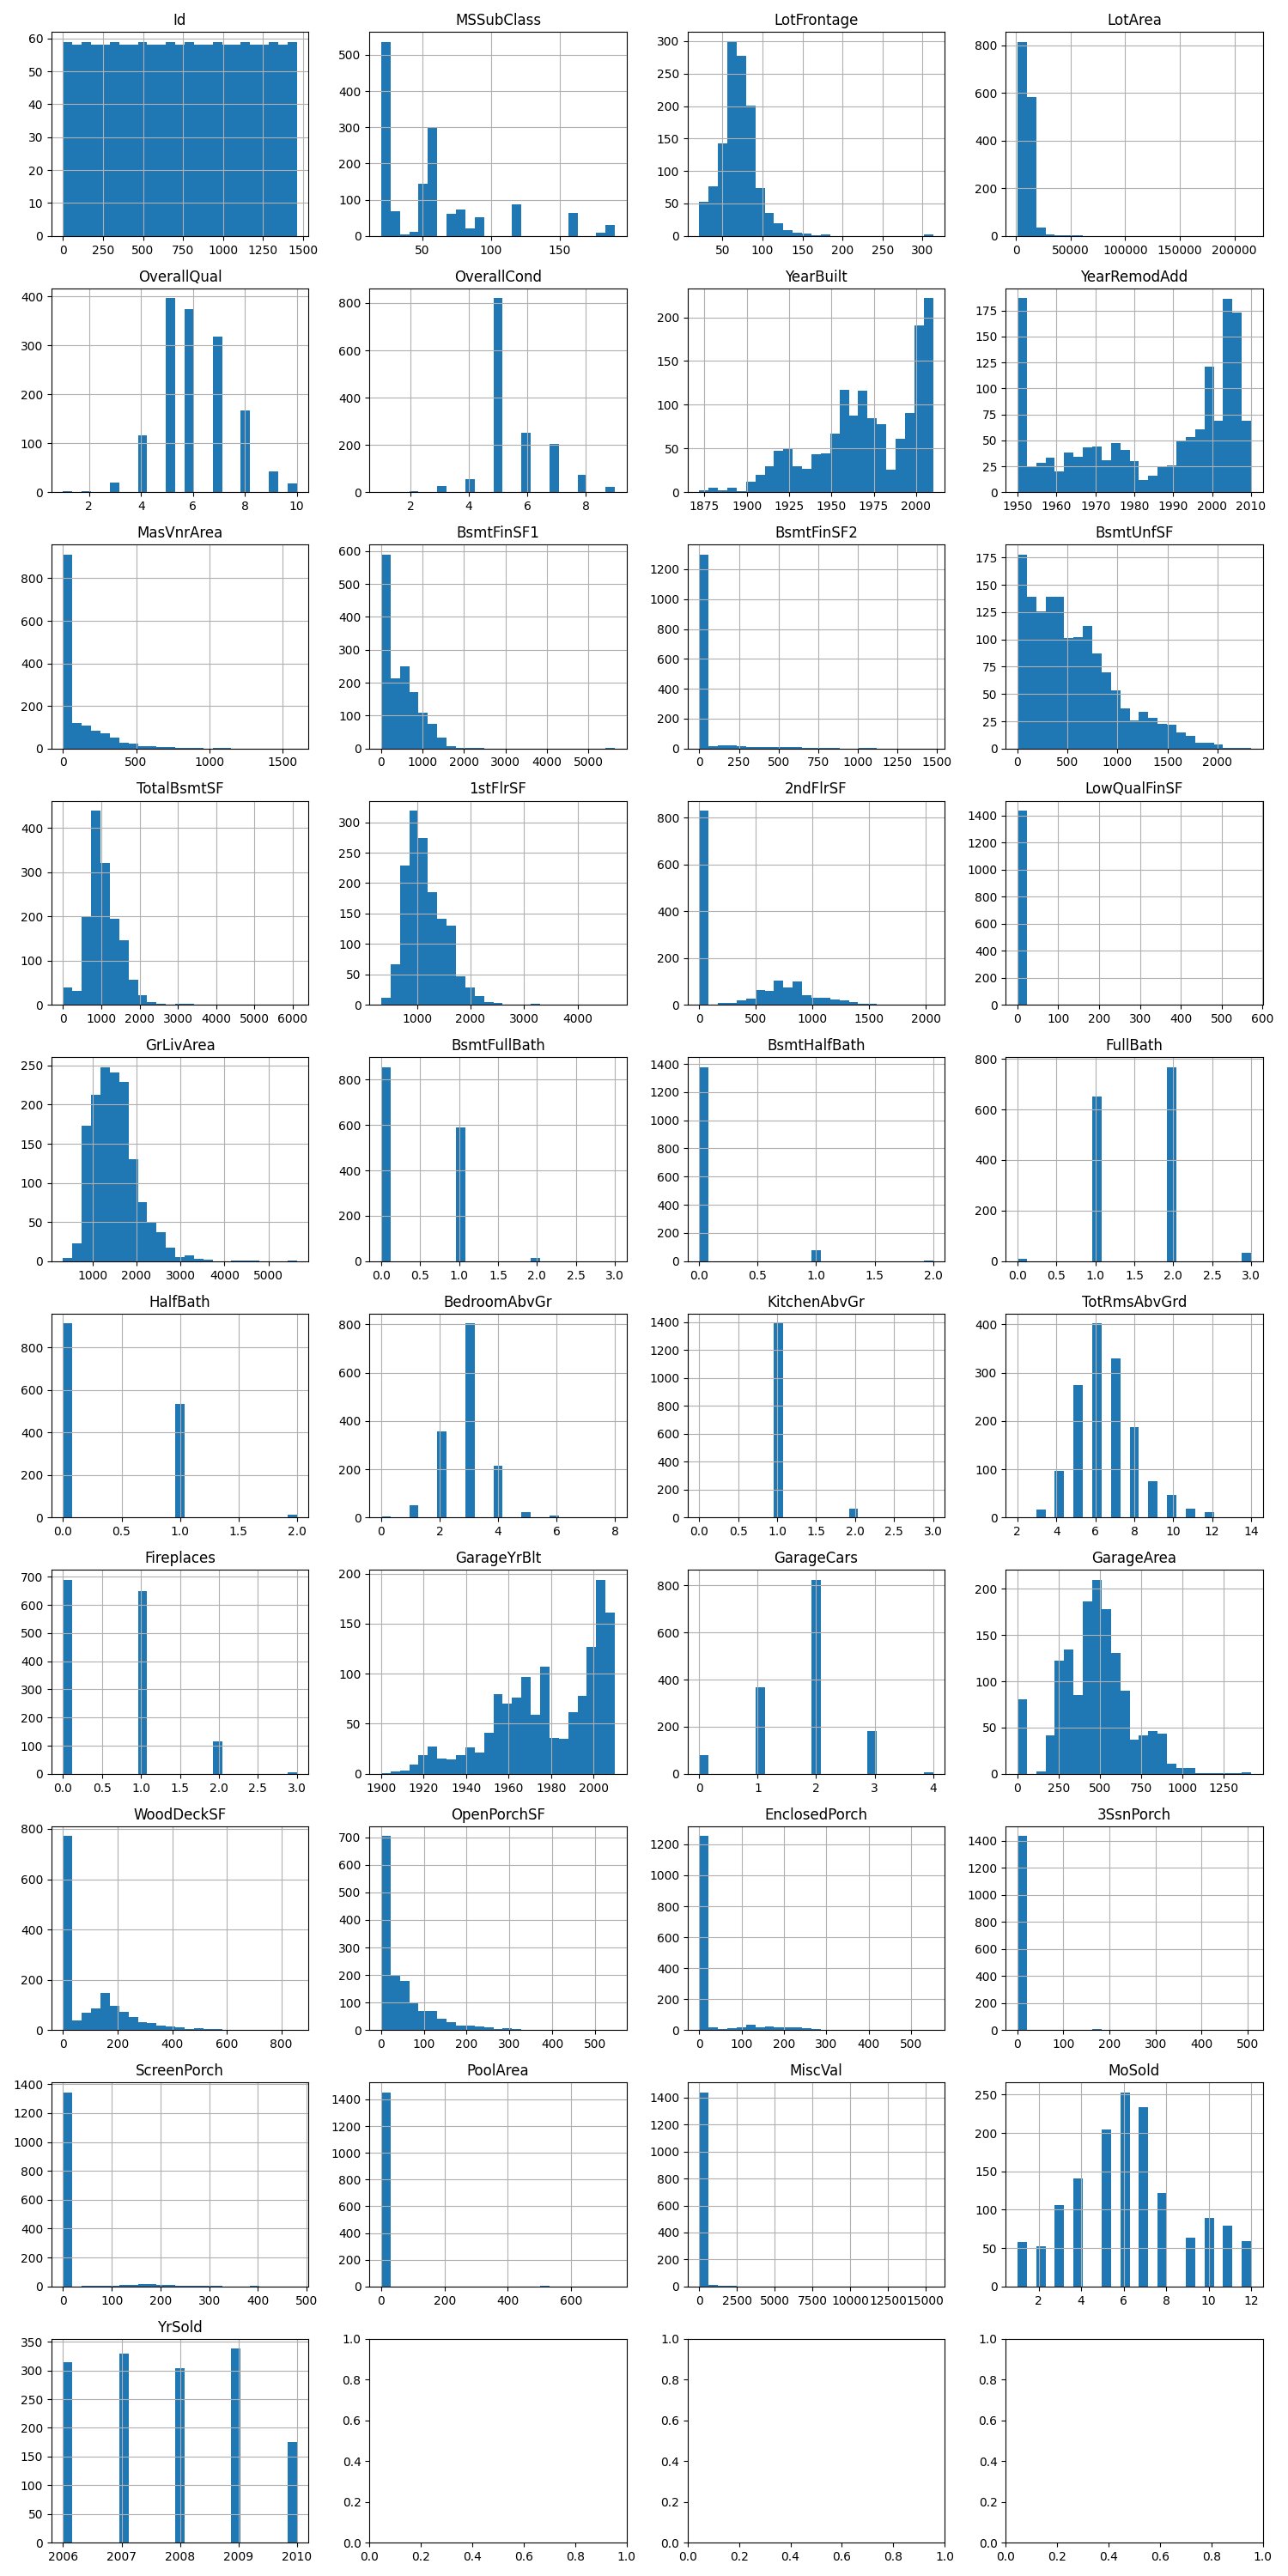

In [142]:
data_analyzer.plot_input_pdfs()

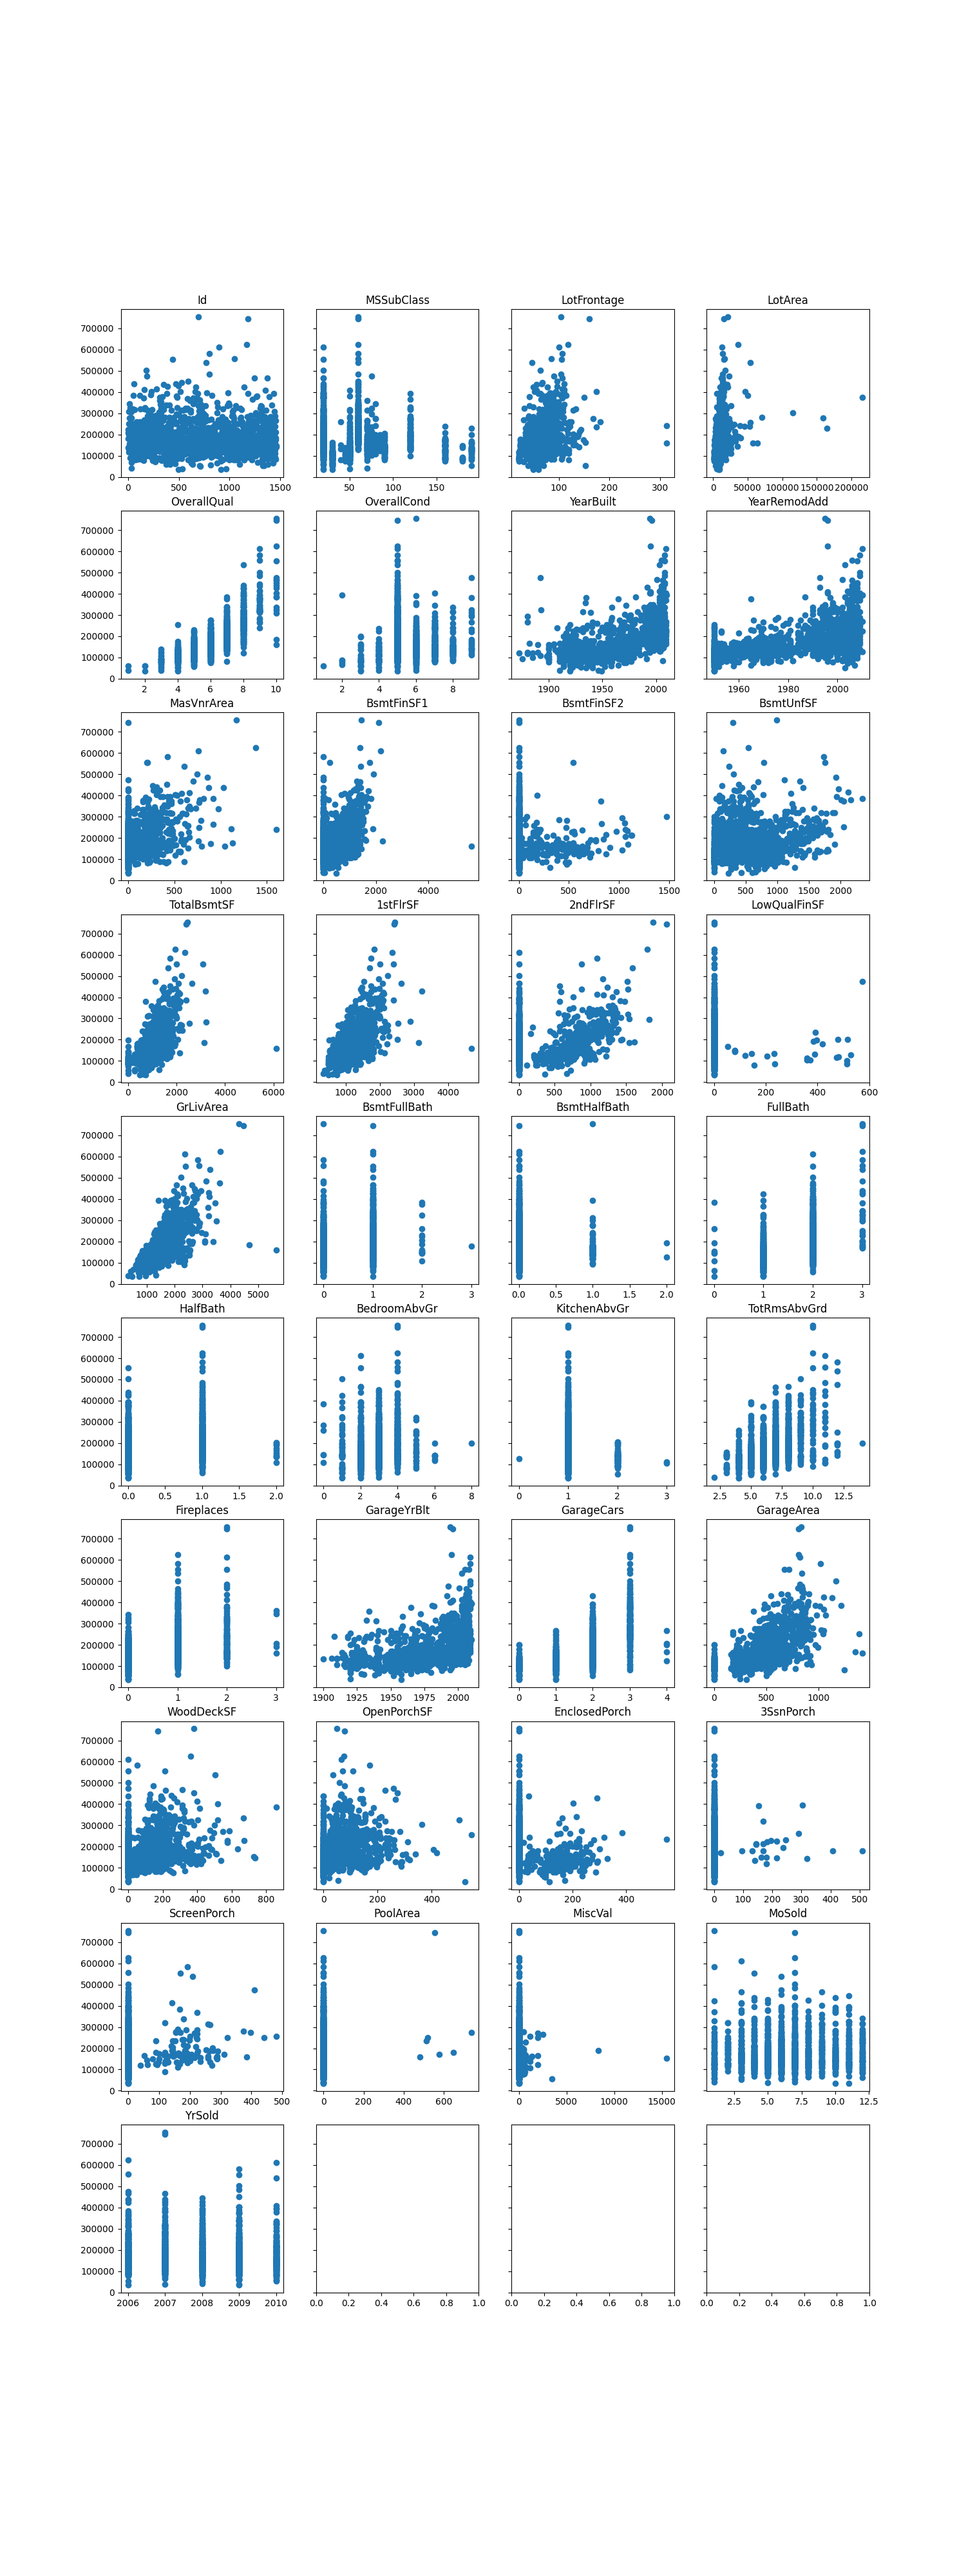

In [154]:
data_analyzer.plot_feature_target_xy()

## Checking test dataset

In [81]:
X_test = pd.read_csv('test.csv')
print(X_test.shape)

(1459, 80)


In [86]:
test_analyzer = DataAnalyzer()
test_analyzer.fit(X_test, None)

Id
 => dtype: int64
 => unique (1459) ...
MSSubClass
 => dtype: int64
 => unique (16) [ 20  60 120 160  80  30  50  90  85 190  45  70  75 180  40 150]
MSZoning
 => dtype: object
 => nulls 4 (0%)
 => unique (6) ['RH' 'RL' 'RM' 'FV' 'C (all)' nan]
LotFrontage
 => dtype: float64
 => nulls 227 (16%)
 => unique (116) ...
LotArea
 => dtype: int64
 => unique (1106) ...
Street
 => dtype: object
 => unique (2) ['Pave' 'Grvl']
Alley
 => dtype: object
 => nulls 1352 (93%)
 => unique (3) [nan 'Pave' 'Grvl']
LotShape
 => dtype: object
 => unique (4) ['Reg' 'IR1' 'IR2' 'IR3']
LandContour
 => dtype: object
 => unique (4) ['Lvl' 'HLS' 'Bnk' 'Low']
Utilities
 => dtype: object
 => nulls 2 (0%)
 => unique (2) ['AllPub' nan]
LotConfig
 => dtype: object
 => unique (5) ['Inside' 'Corner' 'FR2' 'CulDSac' 'FR3']
LandSlope
 => dtype: object
 => unique (3) ['Gtl' 'Mod' 'Sev']
Neighborhood
 => dtype: object
 => unique (25) ...
Condition1
 => dtype: object
 => unique (9) ['Feedr' 'Norm' 'PosN' 'RRNe' 'Artery' 'R